In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from enums import stage_dict, char_dict, platform_dict, dan_names_dict, rank_color_dict
from plotting_utils import plot_categorical_histogram, plot_bar, plot_heatmap

/tmp/ipykernel_1908/1491293918.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
import read_data # weird notebook workaround
notebook_pardir = os.path.dirname(read_data.__file__)
data_dir = os.path.join(notebook_pardir, "plots", "data")
data_dir

'/home/daniel/Tekken8-Match-Stats/plots/data'

In [3]:
df_raw = pd.read_csv(os.path.join(data_dir, "raw_matches.csv"))
df_player = pd.read_csv(os.path.join(data_dir, "player_info.csv"))
df_matchup = pd.read_csv(os.path.join(data_dir, "matchup_info.csv"))

<Axes: >

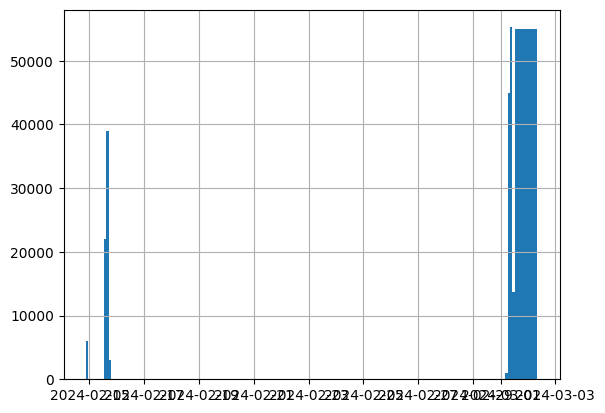

In [15]:
# TODO: make this pretty
pd.to_datetime(df_raw["battleAt"], unit="s").hist(bins=200)

In [5]:
rank_low = 0
rank_high = 29
rank_text = f"{dan_names_dict[rank_low]} to {dan_names_dict[rank_high]}"
df_subset = df_raw[(df_raw["1pRank"] >= rank_low) & (df_raw["1pRank"] <= rank_high) 
                   & (df_raw["2pRank"] >= rank_low) & (df_raw["2pRank"] <= rank_high)
                   & (df_raw["battleType"] == 2)]
df_player_subset = df_player[(df_player["rank_id"] >= rank_low) & (df_player["rank_id"] <= rank_high)]

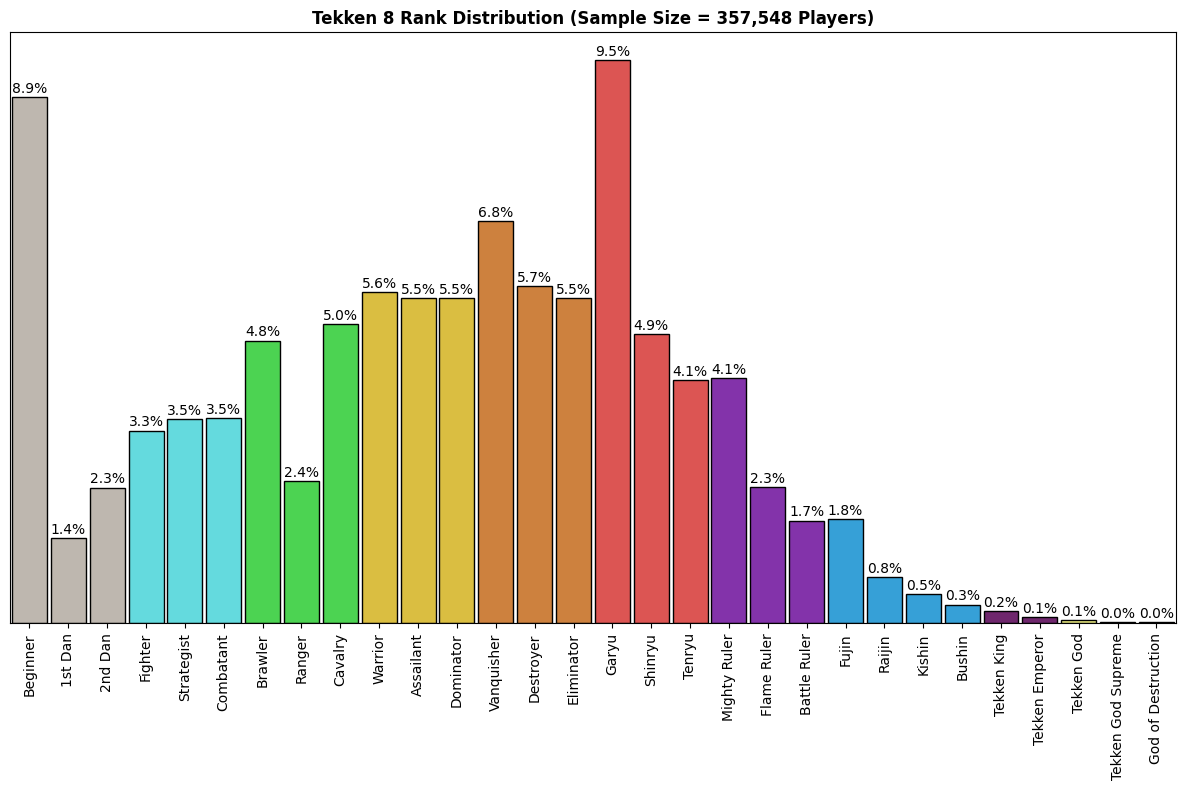

In [6]:
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)

title = f"Tekken 8 Rank Distribution (Sample Size = {len(df_player):,} Player-Character Pairs)"
x = "rank_id"
xlabels = list(dan_names_dict.values())[:-1]
colors = list(rank_color_dict.values())
plot_categorical_histogram(df_player, x, xlabels, colors, title,
                           width=1, gap=0.1, legend=False, edgecolor="black")

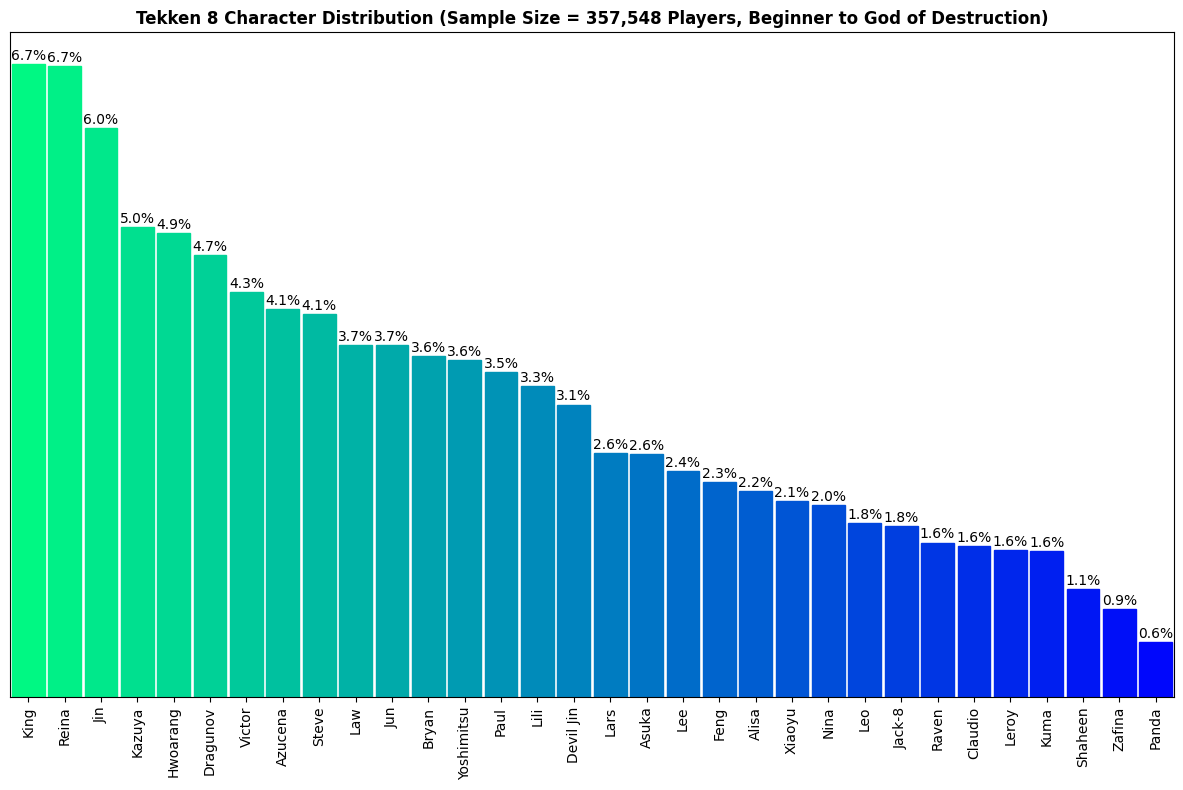

In [7]:
plt.gcf().set_size_inches(12, 8)
plt.gcf().set_dpi(100)

char_ids_by_occurance = df_player_subset.groupby("character_id").count().iloc[:, 0].sort_values(ascending=False).index

title = f"Tekken 8 Character Distribution (Sample Size = {len(df_player_subset):,} Player-Character Pairs, {rank_text})"
x = "character_id"
xlabels = [char_dict[k] for k in char_ids_by_occurance]
colors = sns.color_palette("winter", n_colors=len(char_ids_by_occurance))
plot_categorical_histogram(df_player_subset, x, xlabels, colors, title, order=char_ids_by_occurance,
                           width=1, gap=0.1, legend=False, edgecolor="black")

/tmp/ipykernel_1908/345300262.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wins_1p = df_subset.groupby("1pCharaId").apply(lambda r: (r["winResult"] - 1) == 0).reset_index(level=0).rename(columns={"1pCharaId": "char"})
/tmp/ipykernel_1908/345300262.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_wins_2p = df_subset.groupby("2pCharaId").apply(lambda r: (r["winResult"] - 1) == 1).reset_index(l

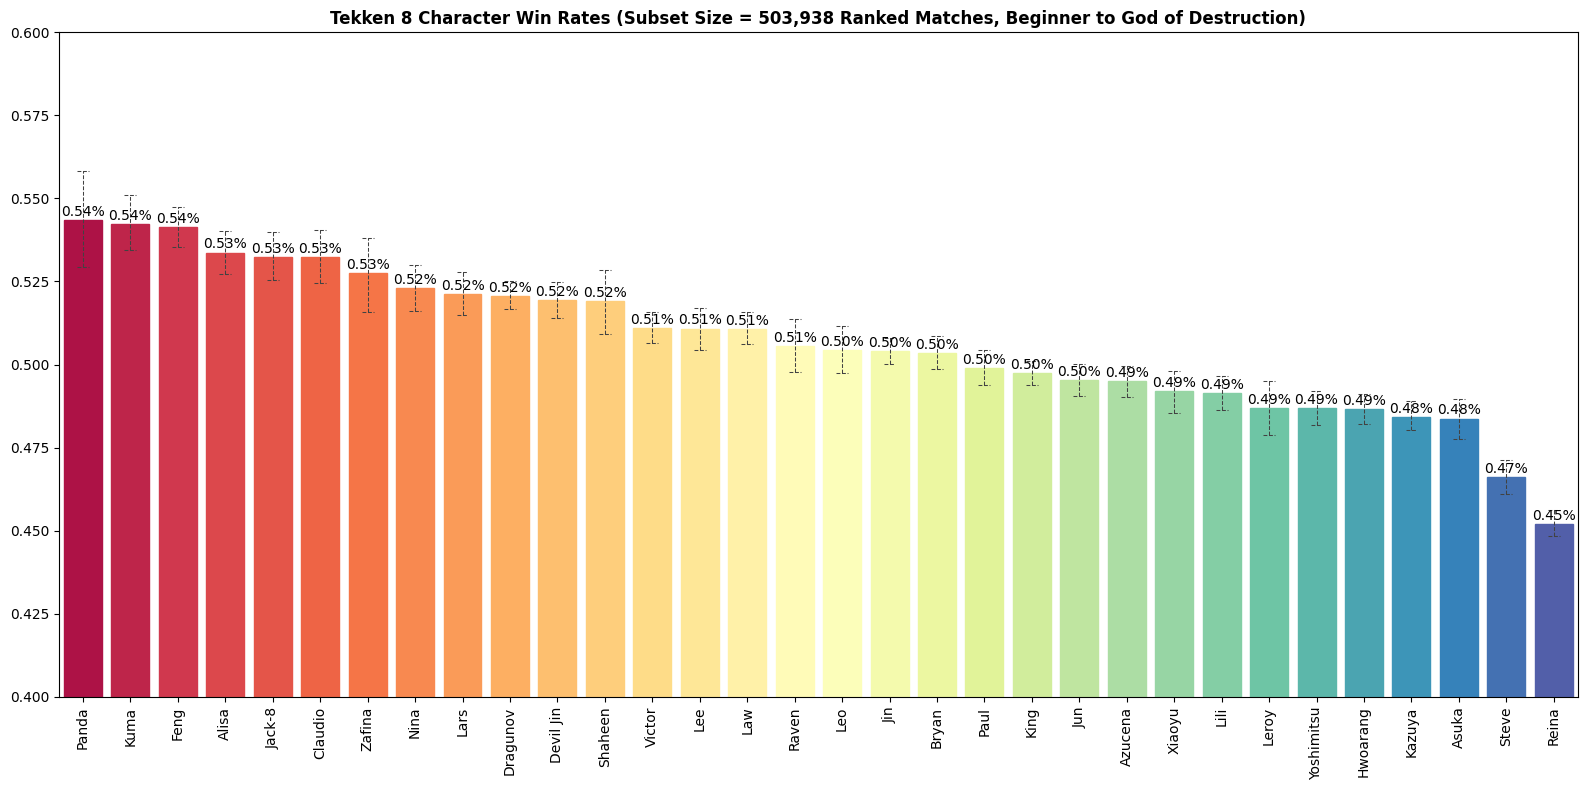

In [8]:
plt.gcf().set_size_inches(16, 8)
plt.gcf().set_dpi(100)

df_wins_1p = df_subset.groupby("1pCharaId").apply(lambda r: (r["winResult"] - 1) == 0).reset_index(level=0).rename(columns={"1pCharaId": "char"})
df_wins_2p = df_subset.groupby("2pCharaId").apply(lambda r: (r["winResult"] - 1) == 1).reset_index(level=0).rename(columns={"2pCharaId": "char"})
df_wins = pd.concat([df_wins_1p, df_wins_2p], ignore_index=True)

order = df_wins.groupby("char").mean().sort_values("winResult", ascending=False).index
title = f"Tekken 8 Character Win Rates (Subset Size = {len(df_subset):,} Ranked Matches, {rank_text})"
x = "char"
y = "winResult"
xlabels = [char_dict[c] for c in order]
colors = sns.color_palette("Spectral_r", n_colors=len(xlabels))
plot_bar(df_wins, x, y, xlabels, colors, title, ylim=(0.4, 0.6), order=order, 
         capsize=0.25, err_kws={'linewidth': 0.75, "linestyle": "--"})

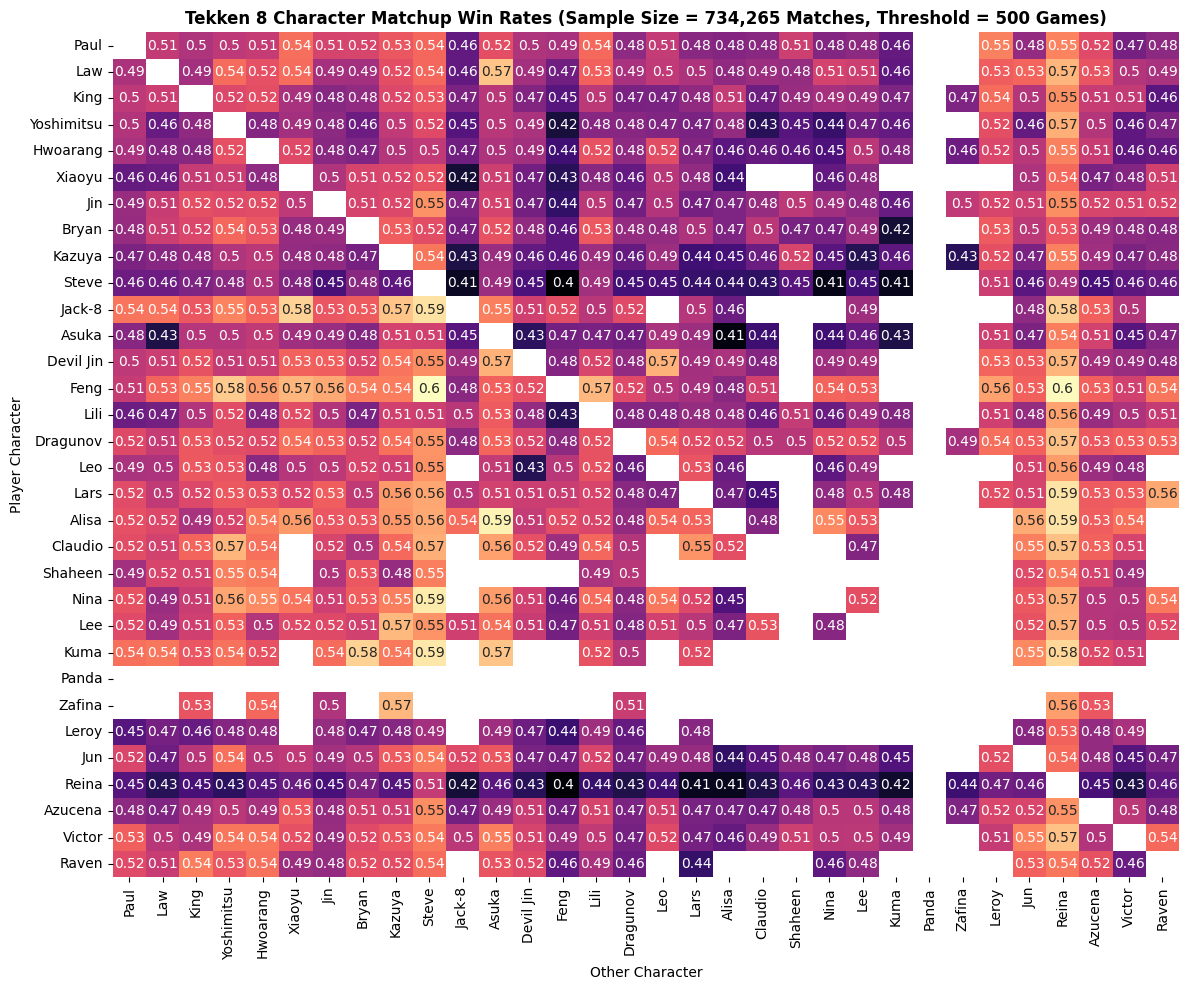

In [9]:
# TODO matchups by rank
plt.gcf().set_size_inches(12, 10)
plt.gcf().set_dpi(100)

mu_wrs = df_matchup.pivot(index="char", columns="other_char").loc[:, "win_rate"]
mu_games = df_matchup.pivot(index="char", columns="other_char").loc[:, "n_games"]
GAME_THRESHOLD = 500
mu_wrs[mu_games < GAME_THRESHOLD] = np.NaN

labels = [char_dict[c] for c in mu_wrs.index]
ylabel = "Player Character"
xlabel = "Other Character"
title = f"Tekken 8 Character Matchup Win Rates (Sample Size = {len(df_raw):,} Matches, Threshold = {GAME_THRESHOLD} Games)"
plot_heatmap(mu_wrs, xlabel, ylabel, labels, labels, title)